## A balanced dataset 
Here we have an almost balanced dataset in terms of the target classes. Therefore, we can used accuracy to evaluate models' performances. 

for data cleaning in generating the bag of words model, TFID and TFIDF and bigram models:
- I made a function called "text_pre_processing" encompasing 6 sub functions to clean the datasets
    - function 1: text_cleaner: this function extracts items such as punctuations, links, accents etc.
    - function 2: clean_nltk_stopwords: this function removes stop words using stop words of nltk package
    - function 3: lemmatizer_nltk: this function lemmatizes the words in tweets. We did not use a stemmer that is based on a series of general rules. Rather I used a lemmatizer that is based on knowledge of English language
    - function 4: emoji_extracter: It extract emojis from the text and remove them.
    - function 5: extract_accents: It normalize character accents.
    - function 6: spell_correction: this function looks for misspelled words and corrects them. It is a computationally expensive operation, so the user can decide if this function should be applied or not

Here I used SGDClassifer for all models for the sake of comparability. The results show that the TFIDF model and TFIDF and bigram model have higher accuracies.
The latter model had better performance in detecting true positives of real disasters. These results make sense as bigrams showed to be different between target labels. 

The bag of Words model outperforms the GloVe model, although I tuned the max iteration in SGDClassifer for the GloVe model. 
Therefore, the use of TFIDF and bigram model might a better choice as it gets the job done and achieves sufficiently high accuracy

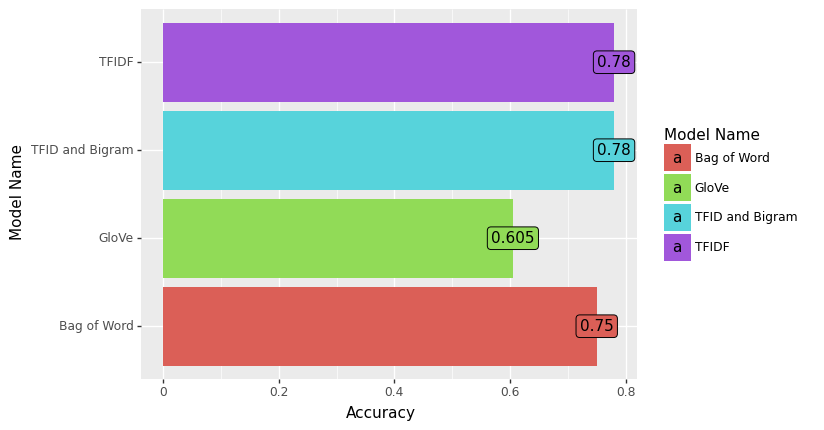

<ggplot: (8784310018030)>

In [313]:

score_accuray= pd.DataFrame([0.75,0.78,0.78,.605],columns=["Accuracy"])
score_model =pd.DataFrame(["Bag of Word","TFIDF","TFID and Bigram","GloVe"],columns=["Model Name"])
models_results = pd.concat([score_accuray,score_model],axis=1)
(models_results >>
 ggplot(aes(x="Model Name",y="Accuracy",fill="Model Name"))
 + geom_col()
+ geom_label(aes(label="Accuracy")) 
+ coord_flip()
)

#### Import required packageds 

In [239]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV 


import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.stem import snowball
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


from collections import defaultdict
from collections import  Counter

import re
import string
from string import digits
import unicodedata
from autocorrect import Speller

from siuba import *
from siuba.dply.forcats import *
from siuba.dply.vector import row_number, lag
import tensorflow as tf

from plotnine import *

import warnings
warnings.filterwarnings("ignore")

import gensim.downloader
#glove_vectors = gensim.downloader.load('glove-twitter-100')


In [2]:
## Import train and test sets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:

## convert tweets to lower
## in train dataset generate a new varaible called disater indicating if a tweet is about real disater or not
train = (train 
>> mutate(text = _.text.str.lower())       
>> mutate(disaster = case_when({_.target ==1:"Real Disaster" ,_.target==0:"Not Disaster", True: 99} ))
>> select(-_.id,-_.keyword, -_.location)      
        )

### Exploratory Data Analaysis

- Proportion of tweets identifed as real disaster
    - About 43% of tweets in training set are about a real disaster. 

In [4]:
# 61 keywords are missing
# 2533 locations are missing 
train.isnull().sum().to_frame().rename(columns={0: "Missing Count"})

,Missing Count
text,0
target,0
disaster,0


In [5]:
# description of the dataset by target categories 
train.groupby("target").describe()

text                                                                 \
       count unique                                                top freq   
target                                                                        
0       4342   4315  the prophet (peace be upon him) said 'save you...    4   
1       3271   3205  11-year-old boy charged with manslaughter of t...   10   

       disaster                              
          count unique            top  freq  
target                                       
0          4342      1   Not Disaster  4342  
1          3271      1  Real Disaster  3271

In [6]:
# the number of distinit values is 7520 
trin = (train
>> distinct(_.text,_.target,_keep_all=True)
)

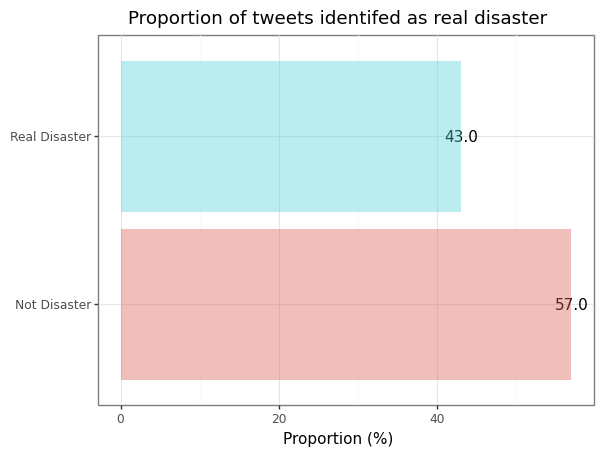

<ggplot: (8784401722384)>

In [7]:
# Is the target balanced? 
# the tareget is almost balanced
(train
>> count(_.disaster)
>> mutate(proportion = _.n/_.n.sum()*100)
>> mutate(proportion = _.proportion.round(1))
>> ggplot(aes("disaster","proportion",fill="disaster")) 
 + geom_text(aes(label="proportion"))
 + geom_col(alpha=0.4) 
 + theme_bw() +
 labs(x="",y="Proportion (%)",title="Proportion of tweets identifed as real disaster") +
 theme(legend_position="none") +
 coord_flip()
)

###  List of Words before cleaning
 - Here we explore the data before cleaning 

In [8]:
# function to make a dataframe of the words in the datset 
def df_maker(initial_df,text,target):
    list_target =  []
    for texts in train[train["target"]==target][text].str.split():
        for words in texts:
            list_target.append(words)
    if target ==1:
        return((pd.DataFrame(pd.DataFrame({'words':list_target})) >> mutate(disaster = "Real Disaster")))
    else:
        return((pd.DataFrame(pd.DataFrame({'words':list_target})) >> mutate(disaster = "Not Real")))
    

In [9]:
## using the function to generate a data frame of words 
df_real = df_maker(initial_df=train,text="text",target =1)
df_not_real = df_maker(initial_df=train,text="text",target =0)

df_unclean = (pd.concat([df_real,df_not_real],axis=0))

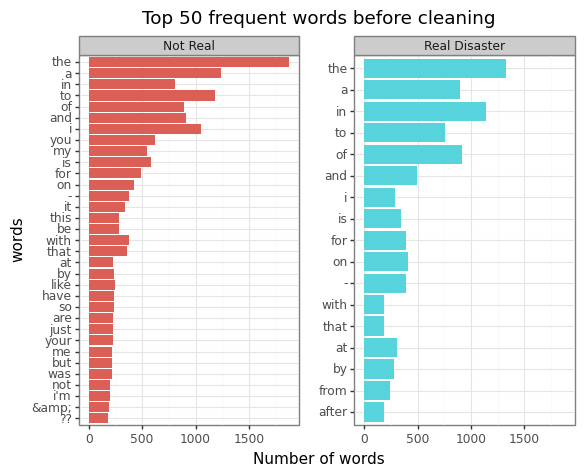

<ggplot: (8784402688509)>

In [10]:
# What are the top 50 frequent words 

before_cleaning_graph =  (df_unclean
 >> group_by(_.disaster,_.words)
 >> count(sort=True) 
 >> ungroup()
 >> group_by(_.disaster) 
 >> arrange(-_.n)
 >> ungroup()
 >> filter(row_number(_) <51)
  >> mutate(words = fct_reorder(_.words,_.n))
 >> ggplot(aes("words","n",fill="disaster")) 
 + geom_col() 
 + coord_flip() 
 + facet_wrap("disaster",scales="free_y") 
 + theme_bw() 
 + theme(subplots_adjust={'wspace': 0.25}) 
 + theme(legend_position="none") +
 labs(title="Top 50 frequent words before cleaning",fill="",y="Number of words")
)

before_cleaning_graph

### Data Cleaning
- Here we make a function called "text_pre_processing" encompasing 6 sub functions to clean the datasets
    - function 1: text_cleaner: this function extracts items such as punctuations, links, accents etc.
    - function 2: clean_nltk_stopwords: this function removes stop words using stop words of nltk package
    - function 3: lemmatizer_nltk: this function lemmatizes the words in tweets. We did not use a stemmer that is based on a series of general rules. Rather I used a lemmatizer that is based on knowledge of English language
    - function 4: emoji_extracter: It extract emojis from the text and remove them.
    - function 5: extract_accents: It normalize character accents.
    - function 6: spell_correction: this function looks for misspelled words and corrects them. It is a computationally expensive operation, so the user can decide if this function should be applied or not

In [11]:

# 1 text cleaner function
def text_cleaner(text):
    # to lower
    text = str(text).lower()
    
    ## remove hidden characters
    printable = r'\w \!"#\$%&\(\)\*\+,\-\./:;<»«؛،ـ\=>\?@\[\\\]\^_\`\{\|\}~'
    text = text.replace(r'[^{}]+'.format(printable), '')
    
    # replace multuispace with single space
    text = text.replace(r'[ ]+', ' ')

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #remove numbers
    
    text = text.translate(str.maketrans('', '', digits))
    
   # remove links
    
    text = re.sub('http\S+', '', text)
    
    #remove html tags
    text = re.sub('<.*?>', '', text)

    
    # remove words in brackets
    text = re.sub('\[.*?\]', '', text)
    
    
    # add space between word and number 
    text = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip() 
    
    return(text)



In [12]:
# Remove stop words
def clean_nltk_stopwords(text):
    
    stop_words_nltk = stopwords.words('english')
    
    text = ' '.join(word for word in text.split(' ') if word not in stop_words_nltk)
    return(text)


In [13]:
## Lemmatizer
# use nltk Lemmatizer to lemmatize words. This is especially the case for tweets
# as people might use words based on the context therefore, we should use lemmatizer
# instead of stemming. This is because a lemmatizer is based on the knowledge of a language
# not a set of generalized rules used in stemming 
# import these modules


def lemmatizer_nltk(text):
    
    lemmatizer = WordNetLemmatizer()
   
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return(text)


In [14]:
# emoji remover 
# extact emoji patterns and remove them
def extract_emojis(text):
    emojies = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emojies, '', text)

In [15]:
# Normalize accent characters 

def extract_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')

In [16]:
# as twitter did not have an edit option where this dataset was collected, it is likely that we have misspelling 

def spell_correction(text):
    
    spell=Speller(lang="en")
   
    text = ' '.join(spell(word) for word in text.split(' '))      
    return(text)    


#### Text Preprosseing function

In [17]:
#### Text Preprosseing function using above function
## generting a pre process function including all four functions:
### 1- text_cleaner, clean_nltk_stopwords, lemmatizer_nltk, spell_correction
### it should be noted that as it takes a long time to correct for spelling in this dataset
### we keep the dataset as it is, however, one can use the function below to correct for spelling 

def text_pre_processing(text,correct_for_spelling=False):
    text = text_cleaner(text)
    text = extract_emojis(text)
    text = extract_accents(text)
    text = clean_nltk_stopwords(text)
    text = lemmatizer_nltk(text)
    
    if correct_for_spelling == True:
        text = spell_correction(text)
    
    return(text)


In [18]:
# Apply the function text_pre_processing to all tweets 
train_clean = train
clean_text = train["text"].apply(text_pre_processing)
train_clean["clean_text"] = clean_text
train_clean

,text,target,disaster,clean_text
0,our deeds are the reason of this #earthquake m...,1,Real Disaster,deed reason earthquake may allah forgive u
1,forest fire near la ronge sask. canada,1,Real Disaster,forest fire near la ronge sask canada
2,all residents asked to 'shelter in place' are ...,1,Real Disaster,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,Real Disaster,people receive wildfire evacuation order calif...
4,just got sent this photo from ruby #alaska as ...,1,Real Disaster,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...
7608,two giant cranes holding a bridge collapse int...,1,Real Disaster,two giant crane holding bridge collapse nearby...
7609,@aria_ahrary @thetawniest the out of control w...,1,Real Disaster,ariaahrary thetawniest control wild fire calif...
7610,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,Real Disaster,utckm volcano hawaii
7611,police investigating after an e-bike collided ...,1,Real Disaster,police investigating ebike collided car little...


In [19]:
# remove meningless words 
words = set(nltk.corpus.words.words())

f = lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words)

train_clean["clean_text"] = train_clean["clean_text"].apply(f)
train_clean

,text,target,disaster,clean_text
0,our deeds are the reason of this #earthquake m...,1,Real Disaster,deed reason earthquake may forgive u
1,forest fire near la ronge sask. canada,1,Real Disaster,forest fire near la canada
2,all residents asked to 'shelter in place' are ...,1,Real Disaster,resident shelter place notified officer evacua...
3,"13,000 people receive #wildfires evacuation or...",1,Real Disaster,people receive wildfire evacuation order
4,just got sent this photo from ruby #alaska as ...,1,Real Disaster,got sent photo ruby smoke wildfire school
...,...,...,...,...
7608,two giant cranes holding a bridge collapse int...,1,Real Disaster,two giant crane holding bridge collapse nearby...
7609,@aria_ahrary @thetawniest the out of control w...,1,Real Disaster,control wild fire even northern part state tro...
7610,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,Real Disaster,volcano
7611,police investigating after an e-bike collided ...,1,Real Disaster,police investigating car little rider serious ...


In [20]:
## generate a data frame of words 
df_real_clean = df_maker(initial_df=train_clean,text="clean_text",target =1)
df_not_real_clean = df_maker(initial_df=train_clean,text="clean_text",target =0)

df_clean = (pd.concat([df_real_clean,df_not_real_clean],axis=0))

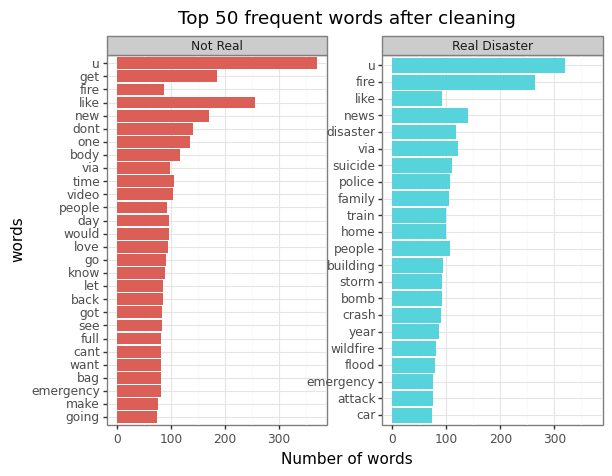

<ggplot: (8784401725706)>

In [21]:
after_cleaning_graph = (df_clean
 >> group_by(_.disaster,_.words)
 >> count(sort=True) 
 >> ungroup()
 >> group_by(_.disaster) 
 >> arrange(-_.n)
 >> ungroup()
 >> filter(row_number(_) <51)
  >> mutate(words = fct_reorder(_.words,_.n))
 >> ggplot(aes("words","n",fill="disaster")) 
 + geom_col() 
 + coord_flip() 
 + facet_wrap("disaster",scales="free_y") 
 + theme_bw() 
 + theme(subplots_adjust={'wspace': 0.25}) 
 + theme(legend_position="none") +
 labs(title="Top 50 frequent words after cleaning",fill="",y="Number of words")
)
after_cleaning_graph

- Comparing the top 50 frequent words before and after cleaning the text is shown below. 
As we can see after cleaning the tweets, the words used in the case of real disaster in tweets are different than the case of not real disaster tweets. 

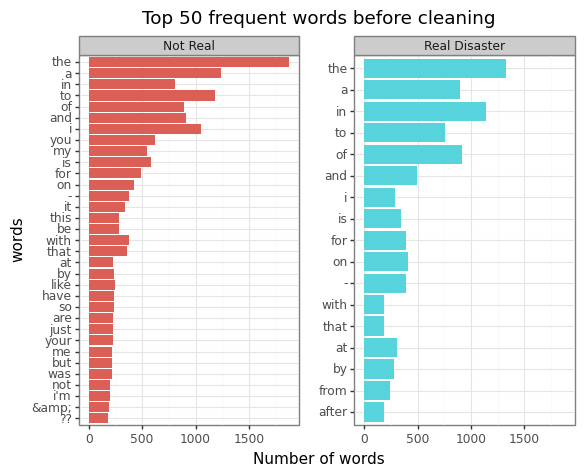

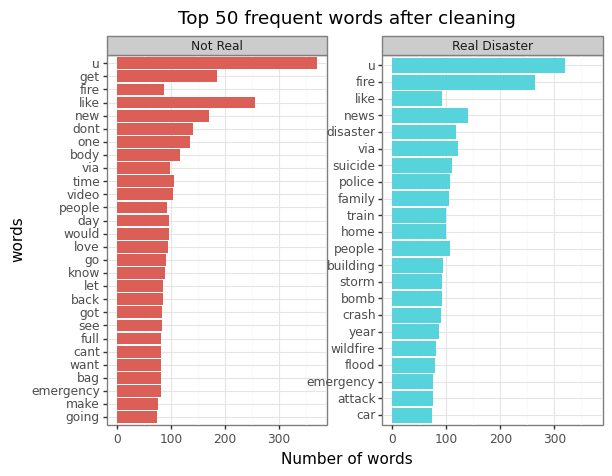

[<ggplot: (8784402688509)>, <ggplot: (8784401725706)>]

In [22]:

graph_to_50 = [before_cleaning_graph,after_cleaning_graph]
graph_to_50 

In [23]:
# bigrams
def get_bigrams(text, n=None):
    vectors = CountVectorizer(ngram_range=(2, 2)).fit(text)
    bag_of_words = vectors.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    freq_of_words = [(word, sum_of_words[0, idx]) for word, idx in vectors.vocabulary_.items()]
    freq_of_words =sorted(freq_of_words, key = lambda x: x[1], reverse=True)
    return freq_of_words[:n]


In [24]:
# generate a data frame of biagrams 
clean_target_real = (train_clean >> filter(_.target==1)  >> select(_.clean_text))
clean_target_not_real = (train_clean >> filter(_.target==0)  >> select(_.clean_text))
bigram_clean = pd.DataFrame(get_bigrams(clean_target_real["clean_text"]),columns=["bigram","Freq"])
bigram_clean = bigram_clean >> mutate(disaster ="Real Disaster")
bigram_not_clean = pd.DataFrame(get_bigrams(clean_target_not_real["clean_text"]),columns=["bigram","Freq"])
bigram_not_clean = bigram_not_clean >> mutate(disaster ="Not Real Disaster")

biagram_clean = (pd.concat([bigram_clean,bigram_not_clean],axis=0))
biagram_clean

,bigram,Freq,disaster
0,suicide bomber,60,Real Disaster
1,oil spill,38,Real Disaster
2,burning building,35,Real Disaster
3,northern wildfire,30,Real Disaster
4,yr old,29,Real Disaster
...,...,...,...
19295,kitten finally,1,Not Real Disaster
19296,siren everywhere,1,Not Real Disaster
19297,bang everyone,1,Not Real Disaster
19298,everyone asleep,1,Not Real Disaster


#### Bigram 
As we can see the bigrams are also differnt across the categories of tweets

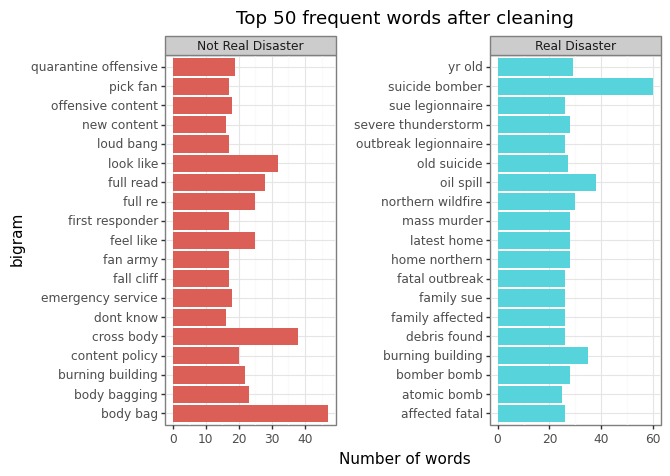

<ggplot: (8784402809417)>

In [25]:
(
biagram_clean 
>> group_by(_.disaster)
>> arrange(-_.Freq)
>> filter(row_number(_) <20)
>> arrange(-_.bigram,-_.Freq)
>> ggplot(aes("bigram","Freq",fill="disaster"))
+ geom_col()
+ facet_wrap("disaster",scales="free")
+ coord_flip()
 + theme_bw() 
 + theme(subplots_adjust={'wspace': 0.9}) 
 + theme(legend_position="none") +
 labs(title="Top 50 frequent words after cleaning",fill="",y="Number of words")
)

### MODELS and PIPLINES 

In [26]:
# first split the train clean into train and test 
X_train, X_test, y_train, y_test = train_test_split(train_clean["clean_text"], train_clean["target"], test_size=0.30, random_state=42)

In [27]:
# Piplines components 
## we have 3 types of transformation: 1- bow, 2-  tfidf , 3-  tfidf and bigram
from sklearn.ensemble import RandomForestClassifier
bage_of_words = CountVectorizer()
tfidf = TfidfVectorizer()
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2))

modle_lr = LogisticRegression()
model_sgd = SGDClassifier(penalty="l2",max_iter=1500)


# 3 piplines with SGD
bow_GSDC_pipe = make_pipeline(bage_of_words,model_sgd)  
tfidf_SGD_pipe = make_pipeline(tfidf,model_sgd)
tifdf_bigram_SGD_pipe = make_pipeline(tfidf_bigram,model_sgd)  
glove_pipe = make_pipeline(model_sgd)

In [28]:
## Function to train and evaluate each pipline 
  
def train_and_evaluete(pipline_name):
    pipline_name.fit(X_train,y_train)
    y_prediction = pipline_name.predict(X_test)
    report = classification_report(y_prediction,y_test,output_dict=False)
    #report_df = pd.DataFrame(report).transpose()
    cm = confusion_matrix(y_test,y_prediction,)
    #cm_plot = ConfusionMatrixDisplay(cm).plot()
    return print(report),print(pd.DataFrame(cm))
    


In [29]:
dict1 = {"Bag of Words":bow_GSDC_pipe,
 "TFIDF" :tfidf_SGD_pipe,
 "TFIDF and Bigram":tifdf_bigram_SGD_pipe,
  #"GloVe":  glove_pipe    
}
for pipes in dict1:
    print("-------------------------------------------------------")
    print(pipes)
    print("-------------------------------------------------------")
    train_and_evaluete(dict1[pipes])

-------------------------------------------------------
Bag of Words
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1339
           1       0.70      0.72      0.71       945

    accuracy                           0.76      2284
   macro avg       0.75      0.75      0.75      2284
weighted avg       0.76      0.76      0.76      2284

      0    1
0  1054  264
1   285  681
-------------------------------------------------------
TFIDF
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1388
           1       0.71      0.77      0.74       896

    accuracy                           0.79      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

      0    1
0  1108  210
1   280  686
-------------------------

In [30]:
# bag of words model and evaluation
(train_and_evaluete(bow_GSDC_pipe))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1360
           1       0.69      0.73      0.71       924

    accuracy                           0.76      2284
   macro avg       0.75      0.75      0.75      2284
weighted avg       0.76      0.76      0.76      2284

      0    1
0  1064  254
1   296  670


(None, None)

In [31]:
# TFID: model and evaluation
(train_and_evaluete(tfidf_SGD_pipe))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1373
           1       0.71      0.76      0.73       911

    accuracy                           0.78      2284
   macro avg       0.77      0.78      0.77      2284
weighted avg       0.78      0.78      0.78      2284

      0    1
0  1096  222
1   277  689


(None, None)

In [32]:
# TFID and biagram: model and evaluation
(train_and_evaluete(tifdf_bigram_SGD_pipe))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1325
           1       0.75      0.75      0.75       959

    accuracy                           0.79      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

      0    1
0  1080  238
1   245  721


(None, None)

In [33]:
dict1 = {"Bag of Words":bow_GSDC_pipe,
 "TFIDF" :tfidf_SGD_pipe,
 "TFIDF and Bigram":tifdf_bigram_SGD_pipe
}
for pipes in dict1:
    print("-------------------------------------------------------")
    print(pipes)
    print("-------------------------------------------------------")
    train_and_evaluete(dict1[pipes])
    

-------------------------------------------------------
Bag of Words
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1364
           1       0.70      0.73      0.72       920

    accuracy                           0.77      2284
   macro avg       0.76      0.76      0.76      2284
weighted avg       0.77      0.77      0.77      2284

      0    1
0  1074  244
1   290  676
-------------------------------------------------------
TFIDF
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1378
           1       0.71      0.76      0.74       906

    accuracy                           0.78      2284
   macro avg       0.77      0.78      0.78      2284
weighted avg       0.79      0.78      0.78      2284

      0    1
0  1100  218
1   278  688
-------------------------

## GloVe

Gensim Word2Vec was used to construct the word embedding using Twitter GloVe (100 D)

In [35]:
# use the clean text generated in previous pre processing

train_gv = (train >> select(_.clean_text,_.target))
train_gv2 = train_gv.sample(frac=1,random_state=3)


In [36]:
# use gensim and generate a GloVe model using glove twitter (can be found on GloVe webpage).
# transform the Glove file to word2vec format to use in gensim 


glove_input_file = "/Users/shh/Downloads/glove.twitter.27B/glove.twitter.27B.100d.txt"
word2vec_output_file = "glove.twitter.100d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

# we only load 200k most common words from Google New corpus 
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) 

In [37]:
# calculate the average values for each array 
def get_mean_vector(tokens_list, vector, generate_missing=False, k=200):
    """
        Calculate average embedding value of sentence from each word vector
    """
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# generate emmbeding using the average value of vector 
def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_mean_vector(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [38]:
embeddings_glove = get_embeddings(glove_model,train_gv2["clean_text"] ,k=100)

In [39]:
train_gv2["glove"] = embeddings_glove
train_gv2

,clean_text,target,glove
1506,catastrophic effect atomic still felt today,1,"[0.22971993555358156, 0.11979639285438975, -0...."
5763,preorder film watch,0,"[0.1448594074279658, 0.06402136449162897, 0.01..."
5157,whereas obliterate national debt give lot new ...,1,"[0.12717934386668409, 0.020040910214003994, 0...."
4550,post dead dozen injured blast near house summe...,1,"[0.18246199341728261, -0.0023634709308252614, ..."
4329,criminal hijack lorry bus photo,1,"[0.25934552516217435, 0.05676851610863401, -0...."
...,...,...,...
7096,thunder pound north go black a deep bruise sky...,1,"[0.18850600685845217, 0.03767831974118104, -0...."
1667,somehow find collide,0,"[0.14874842527788132, 0.042864847276359794, 0...."
3321,want everyone know worried getting supposed ev...,1,"[0.16498418176510873, 0.042828841134905815, 0...."
1688,jazz collide,0,"[0.2200188146865306, 0.14056050265207887, 0.02..."


In [43]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(train_gv2["glove"], train_gv2["target"], test_size=0.33, random_state=42)




In [44]:
# reshape 
X_train_glove_2d = np.stack(X_train_glove)
X_test_glove_2d = np.stack(X_test_glove)


In [46]:

glove_pipe = make_pipeline(SGDClassifier())

In [47]:
def train_and_evaluete_glove(pipline_name,X_train,X_test,y_train,y_test):
    pipline_name.fit(X_train,y_train)
    y_prediction = pipline_name.predict(X_test)
    report = classification_report(y_prediction,y_test,output_dict=False)
    #report_df = pd.DataFrame(report).transpose()
    cm = confusion_matrix(y_test,y_prediction,)
    #cm_plot = ConfusionMatrixDisplay(cm).plot()
    return print(report),print(pd.DataFrame(cm))
    

In [48]:
train_and_evaluete_glove(glove_pipe,X_train_glove_2d, X_test_glove_2d, y_train_glove, y_test_glove)


              precision    recall  f1-score   support

           0       0.44      0.75      0.55       829
           1       0.81      0.52      0.63      1684

    accuracy                           0.60      2513
   macro avg       0.62      0.64      0.59      2513
weighted avg       0.69      0.60      0.61      2513

     0    1
0  625  810
1  204  874


(None, None)

In [229]:
# a function to run SGDClassifier by various max_iter value and store accuracy score to find which max iter gives the highest accuracy
score2 = []

def return_score():
    max_iter_num = np.arange(100, 2000)
    for m_iter in max_iter_num:
            model_sgd_glove = SGDClassifier(max_iter=m_iter,early_stopping=True).fit(X_train_glove_2d,y_train_glove)
            y_prediction = model_sgd_glove.predict(X_test_glove_2d)
            accu = accuracy_score(y_test_glove,y_prediction)
            score2.append(accu)
    return score2,max_iter_num
            

In [230]:
# what max_iter gives us the highet accuracy score 
score3 = return_score()


In [237]:
max_iter_df = pd.DataFrame(score3[1],columns=["max_iter"])
score_sgd_df = (pd.DataFrame(score3[0])>>select(_.score==0))
score_accuracy = pd.concat([max_iter_df,score_sgd_df],axis=1)
(score_accuracy >> filter(_.score == _.score.max()))

,max_iter,score
1244,1344,0.618384
1700,1800,0.618384


### Hyperparameter tuning of SGDClassifier 
- Results:
    - Best Accuracy Score:  0.605
    - Best Parameters: max_iter is 920, 
           

In [284]:
# Hyperparameter tuning
# only a few parameters were chosen 
max_iter = np.arange(100,4000,20)
param_distributions = (dict(max_iter=max_iter))

sgd = SGDClassifier() 
random = RandomizedSearchCV(estimator=sgd, param_distributions=param_distributions, scoring='accuracy', verbose=1, n_jobs=-1, 
n_iter=1000) 
random_result = random.fit(X_train_glove_2d, y_train_glove) 
#print('Best Score: ', random_result.best_score_) 
#print('Best Params: ', random_result.best_params_) 

Fitting 5 folds for each of 195 candidates, totalling 975 fits
